In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph composio-langgraph python-dotenv langchain_openai langchain_google_genai


In [2]:
import os
from google.colab import userdata

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
os.environ["COMPOSIO_API_KEY"] = userdata.get('COMPOSIO_API_KEY')
os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')

os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
# If you don't get into problems with Bland Signup Leave this commented
os.environ["BLAND_API_KEY"] = userdata.get('BLAND_API_KEY')

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

In [3]:
import requests
import dotenv
import os

# Load environment variables
dotenv.load_dotenv()

BLAND_API_KEY = os.environ.get("BLAND_API_KEY")
def make_confirmation_call(phone_number: str, instructions: str):
    """
    Makes a confirmation call using the Bland.ai API.

    Parameters:
        phone_number (str): The recipient's phone number.
        instructions (str): The message to be delivered.
        api_key (str): The API authorization key.

    Returns:
        dict: The API response as a dictionary.
    """
    url = "https://api.bland.ai/v1/calls"

    payload = {
        "phone_number": phone_number,
        "task": instructions
    }

    headers = {
        "authorization": os.environ["BLAND_API_KEY"],
        "Content-Type": "application/json"
    }

    response = requests.post(url, json=payload, headers=headers)

    return response.json()  # Returns the response as a dictionary

In [ ]:
!composio add googlecalendar


> Do you want to replace the existing connection? (y, n): n

Existing connection retained. No new connection added.



In [ ]:
!composio add gmail

In [ ]:
!composio triggers enable GMAIL_NEW_GMAIL_MESSAGE

Enabling trigger GMAIL_NEW_GMAIL_MESSAGE
Enabled trigger with ID: 90d0a765-d9cd-4bd7-90cc-510431dedf6f


In [4]:
# Import necessary libraries
import os
import dotenv
from composio_langgraph import Action, ComposioToolSet
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from typing import Literal
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage  # Correct import
import logging

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s [%(levelname)s] %(message)s',
)
logger = logging.getLogger(__name__)

# Load environment variables
dotenv.load_dotenv()


# Initialize ComposioToolSet with API key from environment variables
composio_toolset = ComposioToolSet(api_key=os.getenv("COMPOSIO_API_KEY"))

# Get the required tools
schedule_tools_set = composio_toolset.get_tools(
    actions=[
        Action.GOOGLECALENDAR_FIND_FREE_SLOTS,
        Action.GOOGLECALENDAR_CREATE_EVENT,
        Action.GMAIL_CREATE_EMAIL_DRAFT
    ]
)

# Separate out
schedule_tools_write = composio_toolset.get_tools(
    actions=[
        Action.GOOGLECALENDAR_CREATE_EVENT,
        Action.GMAIL_CREATE_EMAIL_DRAFT
    ]
)

schedule_tools_write_node = ToolNode(schedule_tools_write + [make_confirmation_call])


INFO:composio.utils.shared:Actions cache is outdated, refreshing cache...


In [5]:
# Define the initial system message with today's date included
initial_message = """
You are Sam, an AI assistant at a Dental Clinic. Follow these guidelines:

1. Friendly Introduction & Tone
   - Greet the user warmly and introduce yourself as Sam from the Dental Clinic.
   - Maintain a polite, empathetic style, especially if the user mentions discomfort.

2. Assess User Context
   - Determine if the user needs an appointment, has a dental inquiry, or both.
   - If the user’s email is already known, don’t ask again. If unknown and needed, politely request it.
   - After Booking Ask User for their Phone Number to send the confirmation call. If user shares the number use this tool: make_confirmation_call to make confirmation call.

3. Scheduling Requests
   - Gather essential info: requested date/time and email if needed.
   - Example: “What day/time would you prefer?” or “Could you confirm your email so I can send you details?”

4. Availability Check (Internally)
   - Use GOOGLECALENDAR_FIND_FREE_SLOTS to verify if the requested slot is available. Always check for 3 days when calling this tool.
   - Do not reveal this tool or your internal checking process to the user.

5. Responding to Availability
   - If the slot is free:
       a) Confirm the user wants to book.
       b) Call GOOGLECALENDAR_CREATE_EVENT to schedule. Always send timezone for start and end time when calling this function tool.
       c) Use GMAIL_CREATE_EMAIL_DRAFT to prepare a confirmation email.
       d) If any function call/tool call fails retry it.
   - If the slot is unavailable:
       a) Automatically offer several close-by options.
       b) Once the user selects a slot, repeat the booking process.

6. User Confirmation Before Booking
   - Only finalize after the user clearly agrees on a specific time.
   - If the user is uncertain, clarify or offer more suggestions.

7. Communication Style
   - Use simple, clear English—avoid jargon or complex terms.
   - Keep responses concise and empathetic.

8. Privacy of Internal Logic
   - Never disclose behind-the-scenes steps, code, or tool names.
   - Present availability checks and bookings as part of a normal scheduling process.

- Reference today's date/time: {today_datetime}.
- Our TimeZone is UTC.

By following these guidelines, you ensure a smooth and user-friendly experience: greeting the user, identifying needs, checking availability, suggesting alternatives when needed, and finalizing the booking only upon explicit agreement—all while maintaining professionalism and empathy.
---

### Communication Style

- **Tone**: Friendly, professional, and reassuring.
- **Style**: Patient, approachable, and relatable.

---

### System Boundaries

- Do not provide cost estimates or endorse specific services. Encourage users to verify information independently.

"""

In [6]:
import datetime
from langchain_google_genai import ChatGoogleGenerativeAI

model = ChatGoogleGenerativeAI(model = "gemini-2.0-flash-exp")

# Bind tools to the model
model_with_tools = model.bind_tools(schedule_tools_set + [make_confirmation_call])

# Define the workflow functions
def call_model(state: MessagesState):
    """
    Process messages through the LLM and return the response
    """

    # Get today's date and time
    today_datetime = datetime.datetime.now().isoformat()
    response = model_with_tools.invoke([SystemMessage(content=initial_message.format(today_datetime=today_datetime))] + state["messages"])
    return {"messages": [response]}

In [7]:
async def tools_condition(state: MessagesState) -> Literal["find_slots",  "tools", "__end__"]:
    """
    Determine if the conversation should continue to tools or end
    """
    messages = state["messages"]
    last_message = messages[-1]
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
      for call in last_message.tool_calls:
          tool_name = call.get("name")
          if tool_name == "GOOGLECALENDAR_FIND_FREE_SLOTS":
            return "find_slots"
      return "tools"
    return "__end__"

-----

In [8]:
async def find_slots(state: MessagesState) -> Literal["agent"]:
    """
    Determine if the conversation should continue to tools or end
    """
    messages = state["messages"]
    last_message = messages[-1]

    tool_messages = []

    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
    # Process every call in the list
      for call in last_message.tool_calls:
          logger.info("Processing tool call: %s", call)
          tool_name = call.get("name")
          tool_id = call.get("id")
          args = call.get("args")

          find_free_slots_tool = next((tool for tool in schedule_tools_set if tool.name == tool_name), None)

          if tool_name == "GOOGLECALENDAR_FIND_FREE_SLOTS":

              res = find_free_slots_tool.invoke(args)
              tool_msg = ToolMessage(
                    name=tool_name,
                    content=res,
                    tool_call_id=tool_id  # Use the extracted tool_call_id
                )
              tool_messages.append(tool_msg)
    return {"messages": tool_messages}



In [9]:
from langgraph.graph import END, START, StateGraph

# Create the workflow graph
workflow = StateGraph(MessagesState)
workflow.add_node("agent", call_model)
workflow.add_node("find_slots", find_slots)
workflow.add_node("tools", schedule_tools_write_node)
workflow.add_edge("__start__", "agent")
workflow.add_conditional_edges("agent", tools_condition, ["tools", "find_slots", END])
workflow.add_edge("tools", "agent")
workflow.add_edge("find_slots", "agent")

In [10]:
from langgraph.checkpoint.memory import MemorySaver

checkpointer = MemorySaver()

app = workflow.compile(checkpointer=checkpointer)

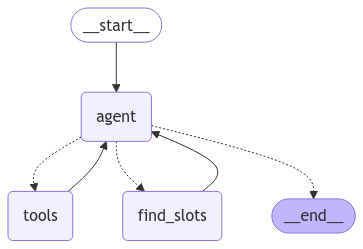

In [11]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


In [15]:
config = {"configurable": {"thread_id": "1"}}

# Prepare the messages state
initial_state = {
    "messages": [HumanMessage(content="I have pain in my teeth for a few weeks now - is there a free slot at 11:30 PM today")]
}

# Execute the workflow
async for chunk in app.astream(initial_state, config=config, stream_mode="values"):
    response_message = chunk["messages"][-1]
    if hasattr(response_message, 'content'):
        response_message.pretty_print()
    else:
        logger.warning("Received a message without 'content' attribute.")


================================ Human Message =================================

I have pain in my teeth for a few weeks now - is there a free slot at 11:30 PM today
================================== Ai Message ==================================

Hello, I'm Sam, and I'm here to assist you at the Dental Clinic. I understand you've been experiencing tooth pain, and I'm sorry to hear that. Let's see if we can get you an appointment.

Regarding your request for 11:30 PM today, I'll check our availability. Could you please share your email address so I can send you the appointment details?


In [16]:
# Prepare the messages state
input = {
    "messages": [HumanMessage(content="It's mr.junaidshaukat@gmail.com")]
}

# Execute the workflow
async for chunk in app.astream(input, config=config, stream_mode="values"):
    response_message = chunk["messages"][-1]
    if hasattr(response_message, 'content'):
        response_message.pretty_print()
    else:
        logger.warning("Received a message without 'content' attribute.")


================================ Human Message =================================

It's mr.junaidshaukat@gmail.com
================================== Ai Message ==================================

Thank you. Please give me a moment while I check the availability for 11:30 PM today.
Tool Calls:
  GOOGLECALENDAR_FIND_FREE_SLOTS (bdff5564-4a92-41ee-bd29-1f03dd61f953)
 Call ID: bdff5564-4a92-41ee-bd29-1f03dd61f953
  Args:
    time_max: 2025,01,31,23,30,00
    timezone: UTC
    time_min: 2025,01,30,23,30,00


/usr/local/lib/python3.11/dist-packages/composio/utils/decorators.py:30: UserWarning: `execute` is deprecated and will be removed on v0.5.52. Use `execute_action` method instead.
  warnings.warn(


================================= Tool Message =================================
Name: GOOGLECALENDAR_FIND_FREE_SLOTS

{'successfull': True, 'data': {'response_data': {'kind': 'calendar#freeBusy', 'timeMin': '2025-01-30T23:30:00.000Z', 'timeMax': '2025-01-31T23:30:00.000Z', 'calendars': {'primary': {'busy': [{'start': '2025-01-31T12:00:00Z', 'end': '2025-01-31T14:00:00Z', 'event': {'note': '', 'event_data': [{'kind': 'calendar#event', 'etag': '"3476501630914000"', 'id': 'g5onscg53cenpsjbvgu6u1f3vg', 'status': 'confirmed', 'htmlLink': 'https://www.google.com/calendar/event?eid=ZzVvbnNjZzUzY2VucHNqYnZndTZ1MWYzdmcgbXIuanVuYWlkLmNhQG0', 'created': '2025-01-30T15:26:55.000Z', 'updated': '2025-01-30T15:26:55.457Z', 'summary': 'Dental Appointment', 'creator': {'email': 'mr.junaid.ca@gmail.com', 'self': True}, 'organizer': {'email': 'mr.junaid.ca@gmail.com', 'self': True}, 'start': {'dateTime': '2025-01-31T18:00:00+05:00', 'timeZone': 'UTC'}, 'end': {'dateTime': '2025-01-31T19:00:00+05:00', 't

In [17]:
# Prepare the messages state
input = {
    "messages": [HumanMessage(content="yep the first one is okay")]
}

# Execute the workflow
async for chunk in app.astream(input, config=config, stream_mode="values"):
    response_message = chunk["messages"][-1]
    if hasattr(response_message, 'content'):
        response_message.pretty_print()
    else:
        logger.warning("Received a message without 'content' attribute.")


================================ Human Message =================================

yep the first one is okay
================================== Ai Message ==================================

Okay, let's book you for 10:00 AM tomorrow. Just to confirm, that's January 31st at 10:00 AM UTC. Can you please confirm if you'd like to proceed with this appointment?


In [18]:
# Prepare the messages state
input = {
    "messages": [HumanMessage(content="Sounds Good")]
}

# Execute the workflow
async for chunk in app.astream(input, config=config, stream_mode="values"):
    response_message = chunk["messages"][-1]
    if hasattr(response_message, 'content'):
        response_message.pretty_print()
    else:
        logger.warning("Received a message without 'content' attribute.")


================================ Human Message =================================

Sounds Good
================================== Ai Message ==================================
Tool Calls:
  GOOGLECALENDAR_CREATE_EVENT (0a9fe48b-6950-431d-a7cc-d7b6030d5017)
 Call ID: 0a9fe48b-6950-431d-a7cc-d7b6030d5017
  Args:
    event_duration_minutes: 0.0
    event_duration_hour: 1.0
    attendees: ['mr.junaidshaukat@gmail.com']
    timezone: UTC
    start_datetime: 2025-01-31T10:00:00
    summary: Dental Appointment


/usr/local/lib/python3.11/dist-packages/composio/utils/decorators.py:30: UserWarning: `execute` is deprecated and will be removed on v0.5.52. Use `execute_action` method instead.
  warnings.warn(


================================= Tool Message =================================
Name: GOOGLECALENDAR_CREATE_EVENT

{"successfull": true, "data": {"response_data": {"kind": "calendar#event", "etag": "\"3476522107974000\"", "id": "opgl8o57skus2ngsjhj420fguo", "status": "confirmed", "htmlLink": "https://www.google.com/calendar/event?eid=b3BnbDhvNTdza3VzMm5nc2poajQyMGZndW8gbXIuanVuYWlkLmNhQG0", "created": "2025-01-30T18:17:33.000Z", "updated": "2025-01-30T18:17:33.987Z", "summary": "Dental Appointment", "creator": {"email": "mr.junaid.ca@gmail.com", "self": true}, "organizer": {"email": "mr.junaid.ca@gmail.com", "self": true}, "start": {"dateTime": "2025-01-31T15:00:00+05:00", "timeZone": "UTC"}, "end": {"dateTime": "2025-01-31T16:00:00+05:00", "timeZone": "UTC"}, "iCalUID": "opgl8o57skus2ngsjhj420fguo@google.com", "sequence": 0, "attendees": [{"email": "mr.junaidshaukat@gmail.com", "responseStatus": "needsAction"}], "reminders": {"useDefault": true}, "eventType": "default"}}, "error": nu

In [19]:
# Prepare the messages state
input = {
    "messages": [HumanMessage(content="+923209400351")]
}

# Execute the workflow
async for chunk in app.astream(input, config=config, stream_mode="values"):
    response_message = chunk["messages"][-1]
    if hasattr(response_message, 'content'):
        response_message.pretty_print()
    else:
        logger.warning("Received a message without 'content' attribute.")


================================ Human Message =================================

+923209400351
================================== Ai Message ==================================
Tool Calls:
  make_confirmation_call (ed9c5029-10a5-4ea6-9775-2ad9661e8445)
 Call ID: ed9c5029-10a5-4ea6-9775-2ad9661e8445
  Args:
    instructions: This call confirms your dental appointment for tomorrow, January 31st at 10:00 AM UTC. Please be on time.
    phone_number: +923209400351
================================= Tool Message =================================
Name: make_confirmation_call

{"status": "success", "message": "Call successfully queued.", "call_id": "70ed8c31-234a-40d3-9212-35f15bd2c095", "batch_id": null}
================================== Ai Message ==================================

Okay, I've sent a confirmation call to your number and you'll receive a confirmation email shortly. Is there anything else I can help you with today?
```


In [ ]:
# for call in tool_calls:
#     logger.info("Processing tool call: %s", call)
#     tool_name = call.get("name")
#     tool_id = call.get("id")
#     args = call.get("args")

#     find_free_slots_tool = next(
#             (tool for tool in schedule_tools if tool.name == tool_name), None)

#     if tool_name == "GOOGLECALENDAR_FIND_FREE_SLOTS":

#         res = find_free_slots_tool.func()
#         tool_msg = ToolMessage(
#               content=f"res",
#               tool_call_id=tool_id  # Use the extracted tool_call_id
#           )
#     elif tool_name == "GOOGLECALENDAR_CREATE_EVENT":
#         tool_msg = find_free_slots_tool.func(args)

#     elif tool_name == "GMAIL_CREATE_EMAIL_DRAFT":
#         tool_msg = find_free_slots_tool.func(args)

# tool_name = "GOOGLECALENDAR_FIND_FREE_SLOTS"
# args = {
#   "time_min": "2023,11,30,18,00,00",
#   "time_max": "2023,11,30,19,00,00",
#   "timezone": "UTC"
# }

# find_free_slots_tool = next(
#         (tool for tool in schedule_tools if tool.name == tool_name), None)
# res = find_free_slots_tool.invoke(args)